In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re 
import string
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [10]:
# Load your data (Fake and True)
data_fake = pd.read_csv(r'Fake.csv')
data_true = pd.read_csv(r'True.csv')

In [11]:
print(data_fake.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  


In [12]:
print(data_true.head())


                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   


In [13]:
# Add a 'class' column to indicate fake (0) and true (1)
data_fake["class"] = 0
data_true["class"] = 1

In [14]:
# Select the last 10 rows for manual testing
data_fake_manual_testing = data_fake.tail(10)
data_true_manual_testing = data_true.tail(10)

In [15]:
# Remove the selected manual testing rows from the datasets
for i in range(23480, 23470, -1):
    data_fake.drop([i], axis=0, inplace=True)
for i in range(21416, 21406, -1):
    data_true.drop([i], axis=0, inplace=True)

In [16]:
data_true.shape

(21407, 5)

In [17]:
data_fake.shape

(23471, 5)

In [18]:
# Set the 'class' column for manual testing data
data_fake_manual_testing['class'] = 0
data_true_manual_testing['class'] = 1

C:\Users\TANMAYA\AppData\Local\Temp\ipykernel_17352\1793345259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fake_manual_testing['class'] = 0
C:\Users\TANMAYA\AppData\Local\Temp\ipykernel_17352\1793345259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_true_manual_testing['class'] = 1


In [19]:
# Concatenate the data into a single DataFrame
data_merge = pd.concat([data_fake, data_true], axis=0)

In [20]:
# Drop unnecessary columns (Data cleaning)
data = data_merge.drop(['title', 'subject', 'date'], axis=1)

In [21]:
data.head()

,text,class
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [22]:
# Check for and handle missing values
data.isnull().sum()

text     0
class    0
dtype: int64

In [23]:
# Shuffle the data
data = data.sample(frac=1)

In [24]:
data.head()

,text,class
14090,Obama has filled his cabinet with radical yes...,0
4055,After watching their Republican nominee insult...,0
2656,WASHINGTON (Reuters) - Dining on rib-eye steak...,1
2756,Donald Trump is an incompetent commander-in-ch...,0
17386,MANILA (Reuters) - The Philippines military c...,1


In [25]:
# Reset the index
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

In [26]:
data.head()

,text,class
0,Obama has filled his cabinet with radical yes...,0
1,After watching their Republican nominee insult...,0
2,WASHINGTON (Reuters) - Dining on rib-eye steak...,1
3,Donald Trump is an incompetent commander-in-ch...,0
4,MANILA (Reuters) - The Philippines military c...,1


In [27]:
# Define a function for text cleaning and formatting
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    return text

In [28]:
# Apply text cleaning to your data
data['text'] = data['text'].apply(clean_text)

In [29]:
data.head()

,text,class
0,obama has filled his cabinet with radical yes...,0
1,after watching their republican nominee insult...,0
2,washington reuters dining on ribeye steak and...,1
3,donald trump is an incompetent commanderinchie...,0
4,manila reuters the philippines military chie...,1


In [30]:
# Split the data into features (X) and target (y)
X = data['text']
y= data['class']

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
# Apply TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [33]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [34]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [35]:
y_pred = logistic_regression.predict(X_test_tfidf)

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy:",accuracy)

Accuracy: 0.9841354723707665


In [33]:
# Generate a classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5860
           1       0.98      0.99      0.98      5360

    accuracy                           0.98     11220
   macro avg       0.98      0.98      0.98     11220
weighted avg       0.98      0.98      0.98     11220



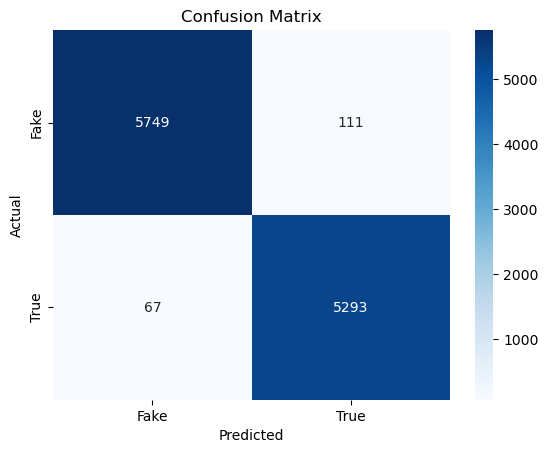

In [34]:
# Plot a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d", xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_resampled, y_train_resampled)

y_pred_knn = knn.predict(X_test_tfidf)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.5319964349376114
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.10      0.19      5828
           1       0.51      0.99      0.67      5392

    accuracy                           0.53     11220
   macro avg       0.73      0.55      0.43     11220
weighted avg       0.74      0.53      0.42     11220



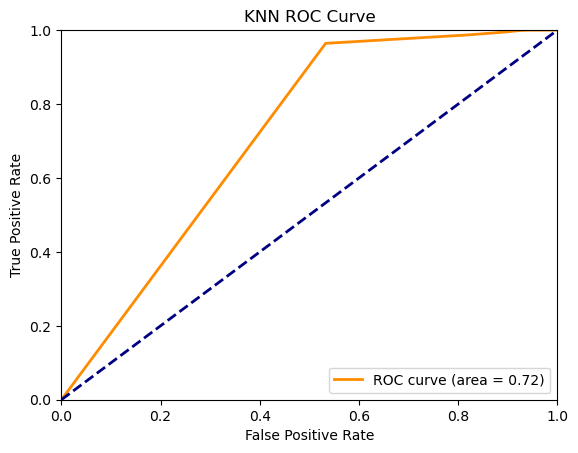

In [33]:
from sklearn.metrics import roc_curve, auc

# Get the probability predictions for KNN
y_prob_knn = knn.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [34]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X_train_resampled, y_train_resampled)

y_pred_svm = svm.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9927807486631016
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5828
           1       0.99      0.99      0.99      5392

    accuracy                           0.99     11220
   macro avg       0.99      0.99      0.99     11220
weighted avg       0.99      0.99      0.99     11220



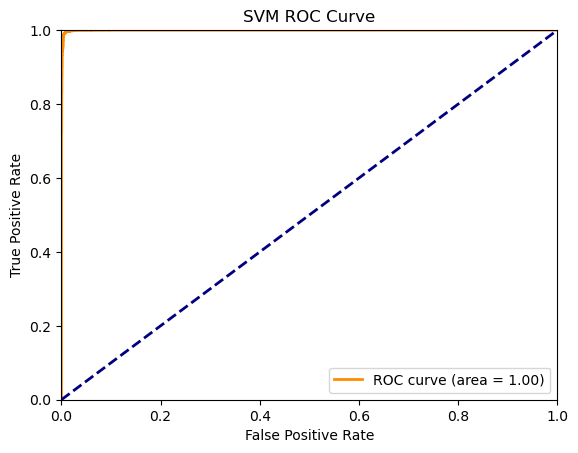

In [37]:
from sklearn.metrics import roc_curve, auc

# Get the decision function for SVM
y_scores_svm = svm.decision_function(X_test_tfidf)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores_svm)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()

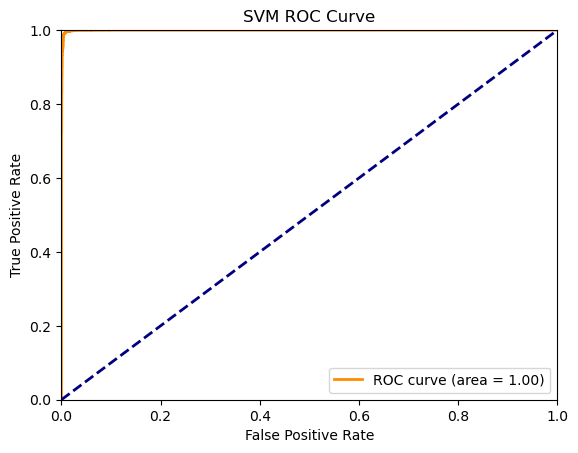

In [37]:
from sklearn.metrics import roc_curve, auc

# Get the decision function for SVM
y_scores_svm = svm.decision_function(X_test_tfidf)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores_svm)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.9850267379679144
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      5828
           1       0.99      0.98      0.98      5392

    accuracy                           0.99     11220
   macro avg       0.99      0.98      0.99     11220
weighted avg       0.99      0.99      0.99     11220



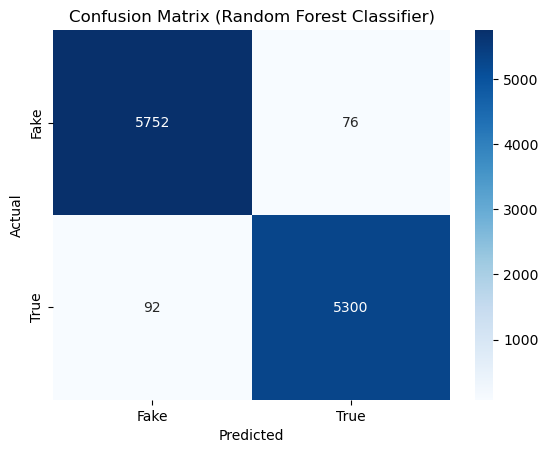

In [35]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_resampled, y_train_resampled)
# Predict the target values on the test data
y_pred_rf = random_forest.predict(X_test_tfidf)
# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

# Generate a classification report
classification_rep_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", classification_rep_rf)

# Plot a confusion matrix
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(confusion_mat_rf, annot=True, cmap="Blues", fmt="d", xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest Classifier)')
plt.show()

Adjusted Rand Index (ARI): 0.004970277020075324
Silhouette Score: 0.011513300206843125
K-means clustering accuracy compared to true labels: 0.5354150573414939


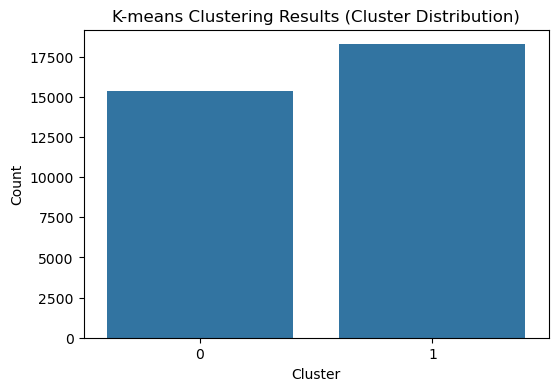

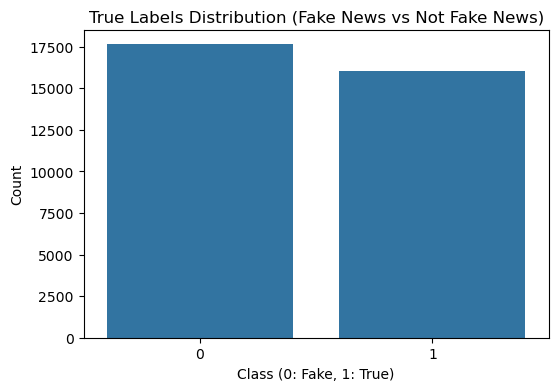

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_tfidf)

# Get the cluster labels
kmeans_labels = kmeans.labels_

# Evaluate K-means clustering with Adjusted Rand Index (ARI)
# ARI is used to compare clustering labels with true labels
ari_score = adjusted_rand_score(y_train, kmeans_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

# Compute the Silhouette Score to evaluate the quality of clustering
silhouette_avg = silhouette_score(X_train_tfidf, kmeans_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Check how well the clustering matches with the true class labels
# Map the K-means labels to original labels (since the clusters are unlabeled, we may need to reverse the labels)
y_train_kmeans_mapped = np.where(kmeans_labels == 0, 1, 0)  # Reverse the labels for a possible match

# Calculate accuracy
accuracy_kmeans = accuracy_score(y_train, y_train_kmeans_mapped)
print(f"K-means clustering accuracy compared to true labels: {accuracy_kmeans}")

# Visualize the distribution of clusters using countplot
plt.figure(figsize=(6, 4))
sns.countplot(x=kmeans_labels)
plt.title('K-means Clustering Results (Cluster Distribution)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Plot the distribution of true labels
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('True Labels Distribution (Fake News vs Not Fake News)')
plt.xlabel('Class (0: Fake, 1: True)')
plt.ylabel('Count')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the training data
y_train_pred = dt_classifier.predict(X_train_tfidf)

# Evaluate the model's performance using accuracy score
accuracy_dt = accuracy_score(y_train, y_train_pred)
print(f"Decision Tree Accuracy on training data: {accuracy_dt}")

# Confusion matrix to evaluate the classifier performance
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print a detailed classification report
print("Classification Report for Decision Tree:")
print(classification_report(y_train, y_train_pred, target_names=['Fake', 'True']))

# Visualize feature importance from the decision tree
plt.figure(figsize=(10, 6))
importance = dt_classifier.feature_importances_
plt.bar(range(len(importance)), importance)
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.show()

In [20]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [23]:
# Predict the target values on the test data
y_pred_dt = decision_tree.predict(X_test_tfidf)

In [25]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy_dt)

Accuracy: 0.9955436720142602


In [26]:
classification_rep_dt = classification_report(y_test, y_pred_dt)
print("Classification Report:\n", classification_rep_dt)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      5860
           1       0.99      1.00      1.00      5360

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220



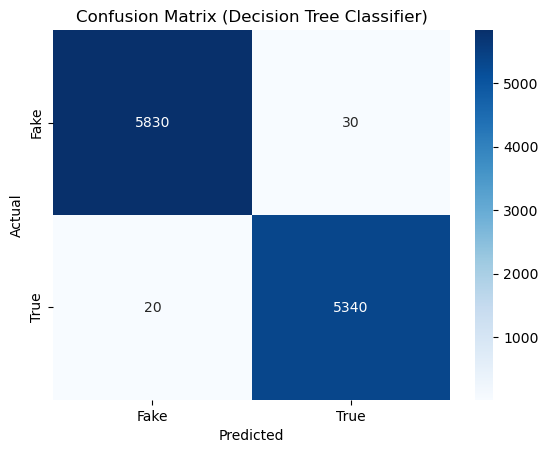

In [35]:
confusion_mat_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(confusion_mat_dt, annot=True, cmap="Blues", fmt="d", xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree Classifier)')
plt.show()

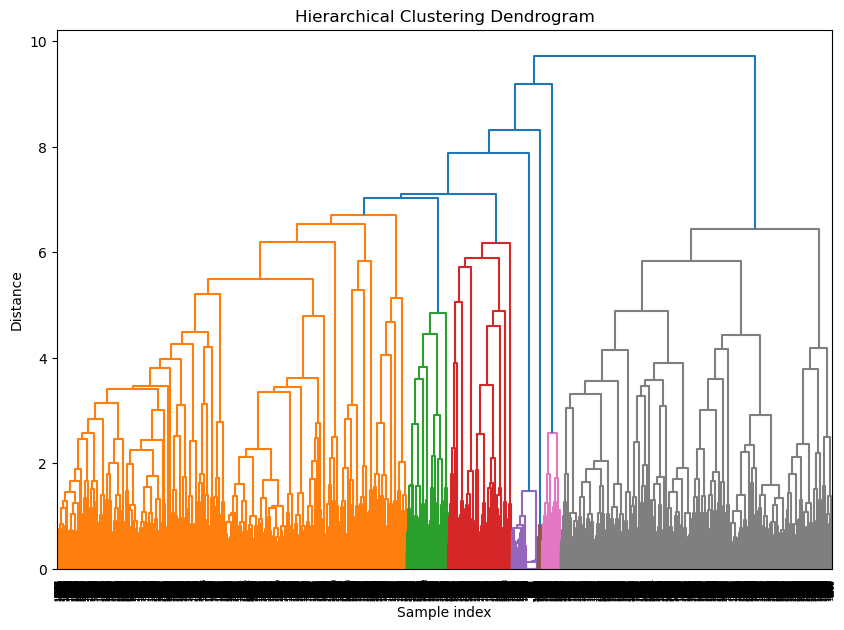

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming you have your TF-IDF matrix as X_test_tfidf

# Reduce dimensions using Truncated SVD
svd = TruncatedSVD(n_components=100)  # Reduce to 100 components
X_reduced = svd.fit_transform(X_test_tfidf)

# Perform hierarchical clustering on reduced data
cluster = AgglomerativeClustering(n_clusters=2, linkage='ward')  # Remove 'affinity'
labels = cluster.fit_predict(X_reduced)

# Generate linkage matrix for dendrogram
linked = linkage(X_reduced, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()